<a href="https://colab.research.google.com/github/LiterallyRicky/DataScience-A2/blob/main/Copy_of_Unit4ExerciesSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import pymc as pm

# Unit 4 Exercises: Tinkering Hierarchical Models

These exercises are designed to force you to look at the nuances of the models we looked at in class, while exploring some "what ifs". There's also some mild data wrangling for you to enjoy at in task6.



**Task1**:

Redo the chemical shift hierarchical model, execpt with all Student T  and Half Student T likelihood and priors.

Then, compare group posteriors of the normal chem shift model with your new Student T model using a ridge plot.

**Answer1:**

Before actually making the models, I need to import the neccessary code first.


In [3]:
#load the data from my github page.
#cs stands for chemical shift data
url_cs = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/chemical_shifts_theo_exp.csv'
#I could have put the url string directly into pd.read_csv()
cs_data = pd.read_csv(url_cs)

In [4]:
#element wise subtraction
diff_TminusE = cs_data.theo - cs_data.exp
#adds a column called 'diff_TminusE' as the fifth column of cs_data
cs_data.insert(loc=4,column='diff_TminusE',value=diff_TminusE)

In [5]:
#identifies all the different amino acids in our data set
#and stores that information, plus original info, in the variable aa_encode
aa_encode = pd.Categorical(cs_data['aa'])
aa_encode

['ILE', 'TYR', 'SER', 'ALA', 'ARG', ..., 'LYS', 'ARG', 'LYS', 'GLU', 'SER']
Length: 1776
Categories (19, object): ['ALA', 'ARG', 'ASN', 'ASP', ..., 'THR', 'TRP', 'TYR', 'VAL']

In [6]:
#Replaces all the amino acid names with a number in the variable aa_idx
aa_idx = aa_encode.codes
aa_idx

array([ 8, 17, 14, ..., 10,  5, 14], dtype=int8)

In [7]:
#stores the category names in a dictionary
#this dictionary format is required
#for pymc to properly read the categories
aa_coords = {"aa": aa_encode.categories}
aa_coords

{'aa': Index(['ALA', 'ARG', 'ASN', 'ASP', 'GLN', 'GLU', 'GLY', 'HIS', 'ILE', 'LEU',
        'LYS', 'MET', 'PHE', 'PRO', 'SER', 'THR', 'TRP', 'TYR', 'VAL'],
       dtype='object')}

**I'm copying and pasting the Normal Chem Shift Model code below**


vvvvvvvvv

In [8]:
with pm.Model(coords=aa_coords) as cs_h_model:
    # hyperpriors. Notice how there's no dims argument.
    #this means that the hyperprior is shared across all amino acids
    μ_mu = pm.Normal('μ_mu', mu = 0, sigma = 10)
    μ_sd = pm.HalfNormal('μ_sd', sigma = 10)

    # priors. There is a different prior for each amino acid,
    #but now the μ priors 'talk' to one another through μ_mu and μ_sd
    μ = pm.Normal('μ',
                  mu = μ_mu,
                  sigma = μ_sd,
                  dims = "aa")

    σ = pm.HalfNormal('σ', sigma = 10,
                      dims = "aa")

    #likelihood; same as before
    y = pm.Normal('y',
                  mu = μ[aa_idx],
                  sigma = σ[aa_idx],
                  observed = cs_data.diff_TminusE)

    #cs for chemshift, h for heirarchical
    idata_cs_h = pm.sample()

Output()

Output()

In [9]:
with pm.Model(coords=aa_coords) as cs_h1_model:
    # Hyperpriors
    μ_mu = pm.StudentT('μ_mu', mu=0, sigma=5, nu=10)
    μ_sd = pm.HalfStudentT('μ_sd', sigma=5, nu=10)
    μ_nu = pm.Exponential('μ_nu', lam=1/10)

    # Priors for each amino acid, adjusting sigma and nu
    μ = pm.StudentT('μ', mu=μ_mu, sigma=μ_sd, nu=μ_nu, dims="aa")
    σ = pm.HalfStudentT('σ', sigma=5, nu=10, dims="aa")
    v = pm.Exponential('ν', lam=1/10, dims="aa")  # Exponential for ν is often more stable

    # Likelihood
    y = pm.StudentT('y',
                    mu=μ[aa_idx],
                    sigma=σ[aa_idx],
                    nu=v[aa_idx],
                    observed=cs_data.diff_TminusE)
    #sampling the student T model
    idata_cs_h1 = pm.sample()

Output()

Output()

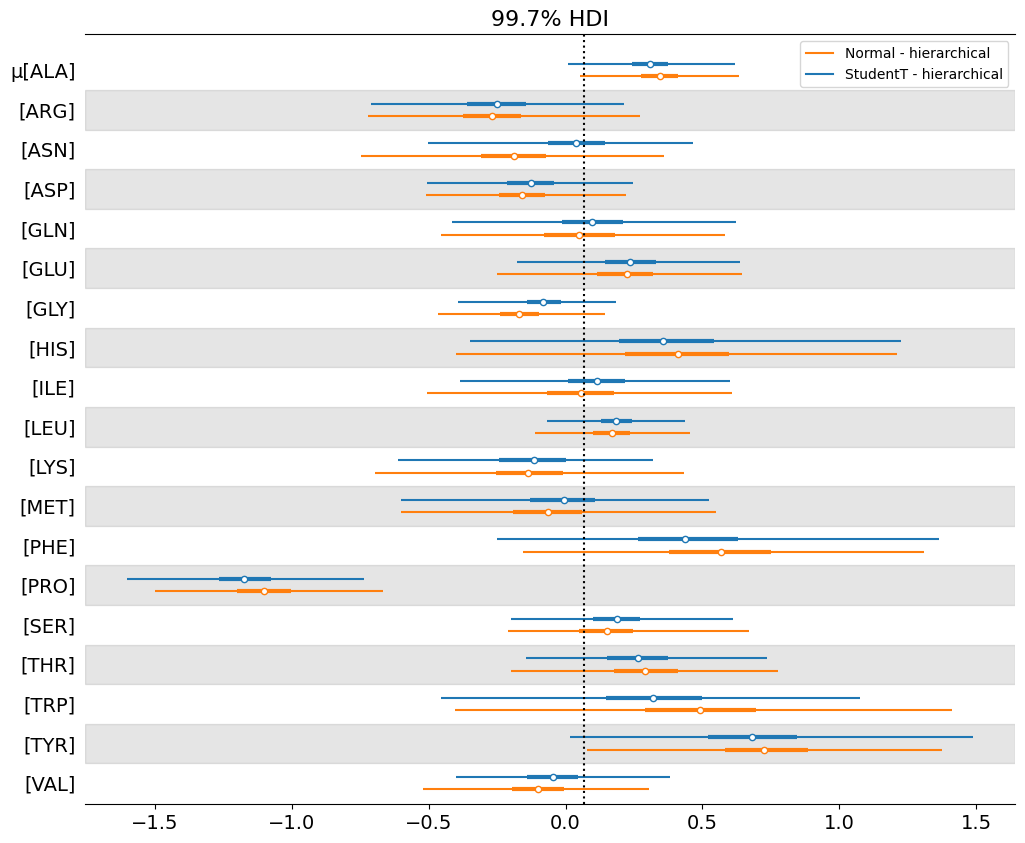

In [10]:
axes = az.plot_forest([idata_cs_h1, idata_cs_h], kind="forestplot",
                      model_names=['StudentT - hierarchical', 'Normal - hierarchical'],
                      var_names='μ', combined=True, figsize=(12, 10),hdi_prob=0.997)

#plots overall mean of the hierarchical model; do not confuse with 0
y_lims = axes[0].get_ylim()
axes[0].vlines(idata_cs_h.posterior['μ_mu'].mean(), *y_lims, color="k", ls=":");

**Task2**:

Run a posterior predictive check for both models. Which seems to fit the data better?

**First PPC for the Normal hierarchial model:**

In [11]:
pm.sample_posterior_predictive(idata_cs_h, model = cs_h_model, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

<Axes: xlabel='y'>

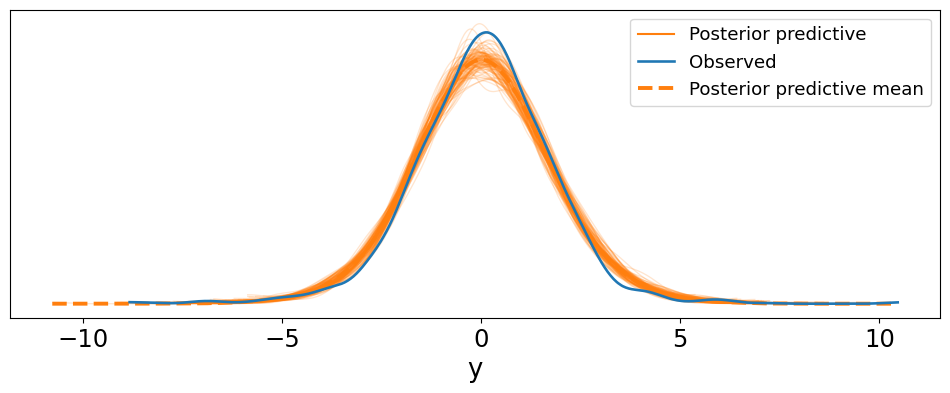

In [12]:
az.plot_ppc(idata_cs_h, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

**Second PPC for the StudentT hierarchial model:**

In [13]:
pm.sample_posterior_predictive(idata_cs_h1, model = cs_h1_model, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

(-10.0, 15.0)

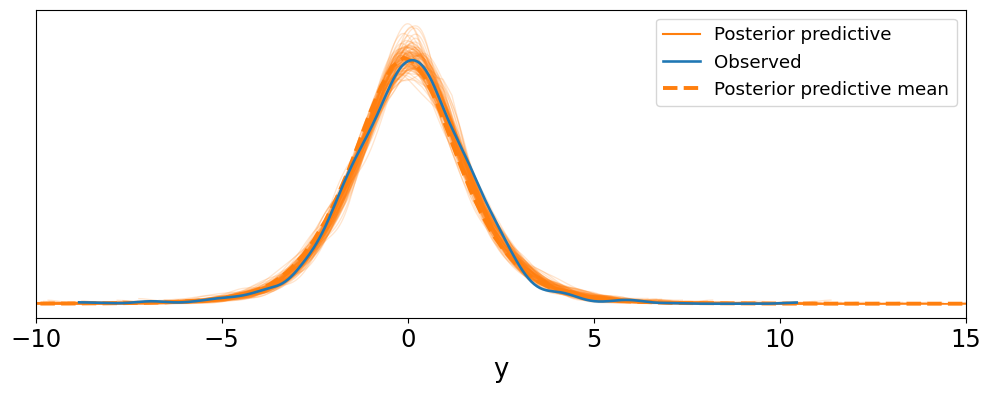

In [14]:
ax = az.plot_ppc(idata_cs_h1, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])
# without x limits, the models seems 'zoomed out', so I'll be adding x limits
#*I'm just trying to show the observed line better*
ax.set_xlim(-10, 15)

**Answer2 CTD:**

Due to the peak matching way better in the second model (StudentT) compared to the first model (Normal), I would have to say that StudentT model fits the data better.

**Task3**:

Redo the soccer model, but this time, assume the groups are independent. This will be a non-hierarchical model.

Before altering the original soccer model, we must import the data into Colab and make our variabled actually defined.

In [3]:
#load the data from my github page.
#sccr stands for soccer
url_sccr = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/football_players.csv'
sccr_data = pd.read_csv(url_sccr,dtype={'position':'category'})

In [8]:
#this is an array of the soccer positions,
#except they are given an int (number) label instead of a string (of letters)
pos_idx = sccr_data.position.cat.codes.values

#an array of the four strings that represent position
pos_codes = sccr_data.position.cat.categories

#puts coords in a dict, so pymc can read them
sccr_coords = {"pos": pos_codes}

Altering the model:

In [17]:
with pm.Model(coords=sccr_coords) as sccr_model_nh:
    # Parameters for each position (independent groups)
    μ_p = pm.Beta('μ_p', alpha=2, beta=20, dims="pos")
    ν_p = pm.Gamma('ν_p', mu=55, sigma=45, dims="pos")

    # Parameter for each player based on their position
    θ = pm.Beta('θ', mu=μ_p[pos_idx], nu=ν_p[pos_idx])

    # Likelihood for goals scored by each player
    _ = pm.Binomial(
        'gs',
        n=sccr_data.shots.values,  # Shots per player
        p=θ,                        # Probability of scoring per shot
        observed=sccr_data.goals.values  # Observed goals per player
    )

    # Increase target_accept to reduce divergences
    idata_sccr_nh = pm.sample(target_accept=0.95)

Output()

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


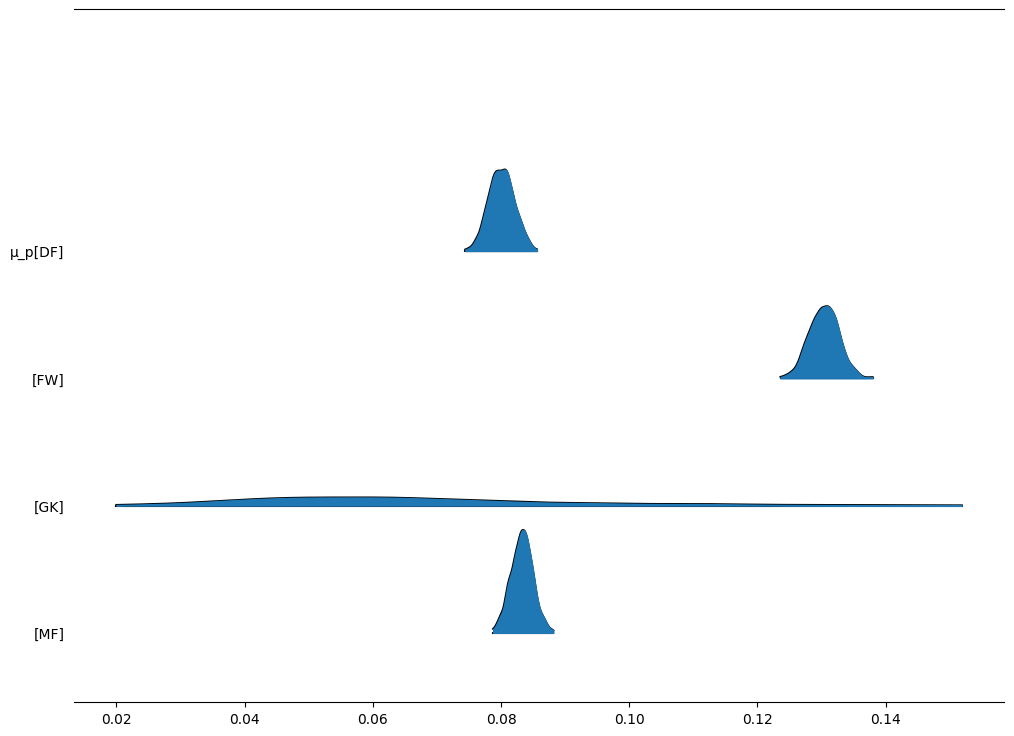

In [18]:
axes = az.plot_forest(idata_sccr_nh, kind="ridgeplot",
                      var_names='μ_p',
                      combined=True, figsize=(12, 9), hdi_prob=0.997)

**Task4**:

Run plot trace and rhat on your inference data object for the non-hierarchical soccer model. How does this compare to the hierarchical model?

**Running plot trace:**

array([[<Axes: title={'center': 'θ'}>, <Axes: title={'center': 'θ'}>],
       [<Axes: title={'center': 'μ_p'}>, <Axes: title={'center': 'μ_p'}>],
       [<Axes: title={'center': 'ν_p'}>, <Axes: title={'center': 'ν_p'}>]],
      dtype=object)

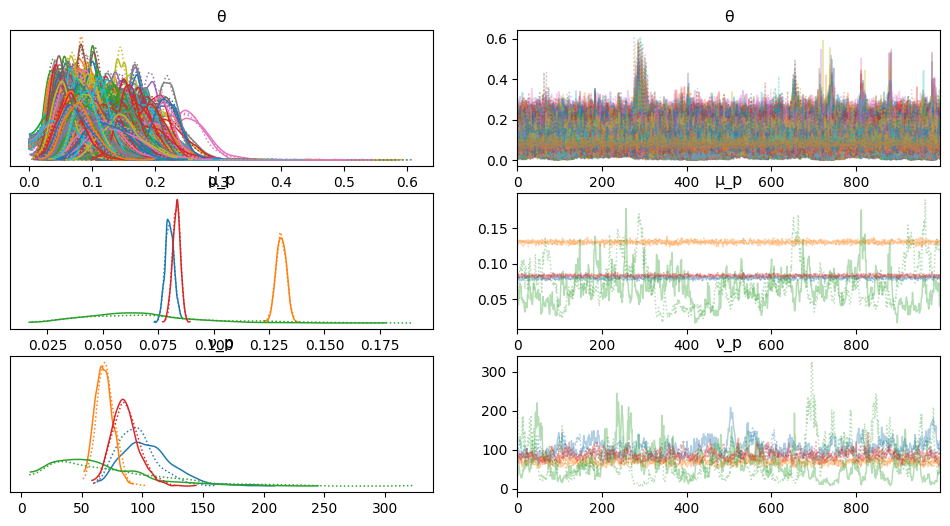

In [ ]:
az.plot_trace(idata_sccr_nh)

**Running rhat:**

In [20]:
az.rhat(idata_sccr_nh)

<xarray.Dataset> Size: 43kB
Dimensions:  (θ_dim_0: 2682, pos: 4)
Coordinates:
  * θ_dim_0  (θ_dim_0) int64 21kB 0 1 2 3 4 5 ... 2676 2677 2678 2679 2680 2681
  * pos      (pos) <U2 32B 'DF' 'FW' 'GK' 'MF'
Data variables:
    θ        (θ_dim_0) float64 21kB 1.001 1.003 1.002 1.0 ... 0.9997 1.001 1.0
    μ_p      (pos) float64 32B 1.003 1.001 1.04 1.003
    ν_p      (pos) float64 32B 1.007 1.001 1.014 1.018

**Answer 4 CTD:**

Without the hyperpriors, we don't really have as many graphs. Overall, they're better compared to the hierarchial but don't really have much difference.

**Task5**:

Plot the posterior of the means for each soccer position in the non-hierarchical model.

How do these posteriors compare to the hierarchical model we did in class?

**Answer5:**

array([<Axes: >], dtype=object)

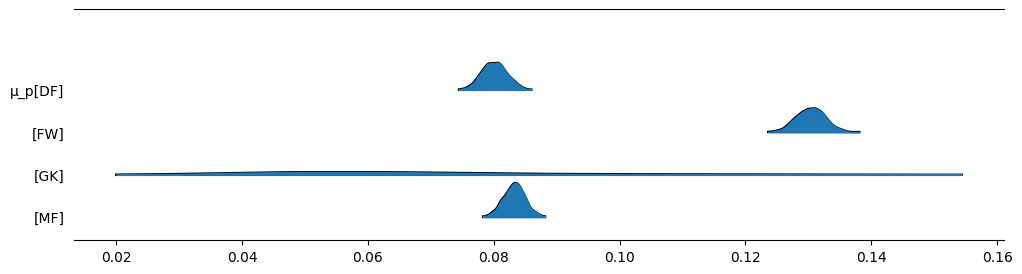

In [19]:
az.plot_forest(idata_sccr_nh, var_names=['μ_p'], combined=True, figsize=(12, 3), kind = 'ridgeplot', hdi_prob=0.998)

**Answer5 CTD.:**

To be honest, they're really similar. GK is surprisingly hard to model which is shown between both models, which could possibly mean that the GK is influencing some of the positions? It'll be interesting to see in the next Task!

**Task6**:

Redo the soccer model as a hierarchical model, but remove all the goalkeepers (GK) from the data. In other words, run a hierarchical model on only the defenders, midfielders, and forwards.

First, I'll be copying and pasting the url once again down here. Now all we need to do is filter out the rows where position is 'GK'.

In [24]:
# Load the data from the GitHub page.
data_sccr_nGK = pd.read_csv('https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/football_players.csv', dtype={'position': 'category'})
data_sccr_nGK = data_sccr_nGK[data_sccr_nGK['position'] != 'GK']

pos_idx_nGK = data_sccr_nGK.position.cat.codes.values
pos_codes_nGK = data_sccr_nGK.position.cat.categories
sccr_coords_nGK = {"pos": pos_codes_nGK}

#now actual making the model:
with pm.Model(coords=sccr_coords_nGK) as model:
    # Hyperparameters
    μ = pm.Beta('μ', alpha=2, beta=20)
    ν = pm.Gamma('ν', mu=55, sigma=45)

    # Parameters for positions
    μ_p = pm.Beta('μ_p', mu=μ, nu=ν, dims="pos")
    ν_p = pm.Gamma('ν_p', mu=55, sigma=45, dims="pos")

    # Parameter for players
    θ = pm.Beta('θ', mu =μ_p[pos_idx_nGK], nu =ν_p[pos_idx_nGK])

    # Observed data - adjust `data_sccr_nGK` variable name
    _ = pm.Binomial('gs',
                    n=data_sccr_nGK.shots.values,   # Shots for each player
                    p=θ,                            # Guess of goals per shot
                    observed=data_sccr_nGK.goals.values)  # Goals per player

    # Sample with target_accept increased to reduce divergences
    idata_sccr_nGK = pm.sample(target_accept=0.99)


Sampling chain 1, 0 divergences ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 / 0:04:22

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


**Task7**:

Compare the plot trace and rhat results for the hierarchical model with GKs and without GKs. Then answer the following questions:
- Which model was easier for pymc to process?
- What do we lose by dropping Gks from the data set? What do we gain?

array([[<Axes: title={'center': 'θ'}>, <Axes: title={'center': 'θ'}>],
       [<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'μ'}>],
       [<Axes: title={'center': 'μ_p'}>, <Axes: title={'center': 'μ_p'}>],
       [<Axes: title={'center': 'ν'}>, <Axes: title={'center': 'ν'}>],
       [<Axes: title={'center': 'ν_p'}>, <Axes: title={'center': 'ν_p'}>]],
      dtype=object)

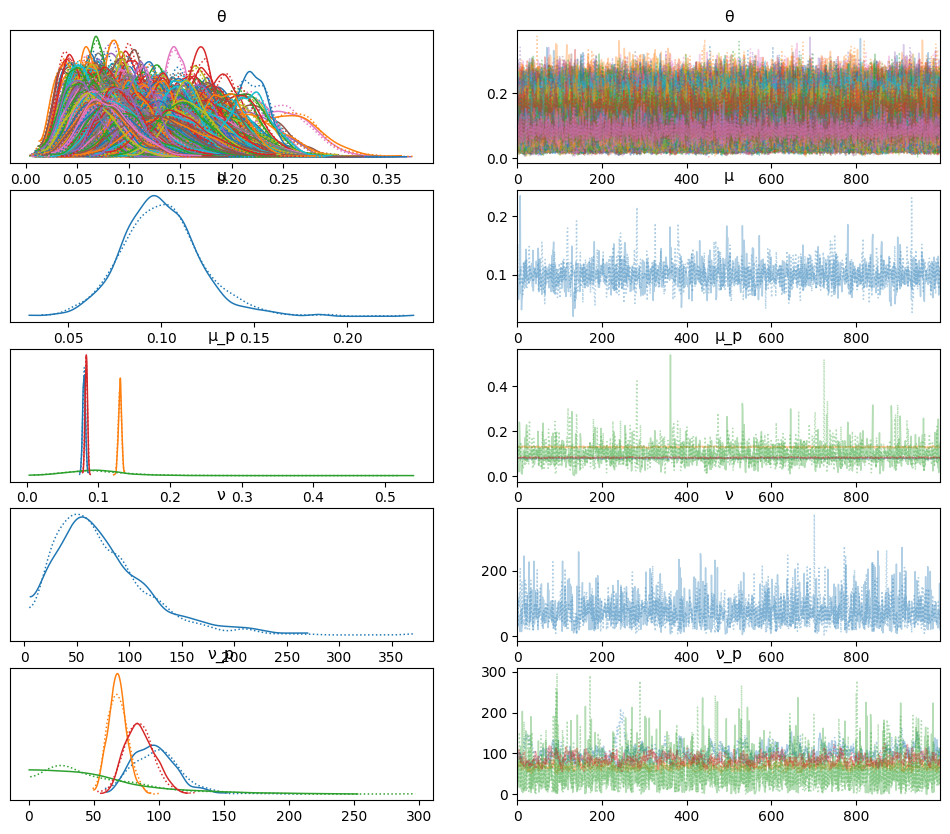

In [25]:
az.plot_trace(idata_sccr_nGK)

In [26]:
az.rhat(idata_sccr_nGK)

<xarray.Dataset> Size: 40kB
Dimensions:  (θ_dim_0: 2517, pos: 4)
Coordinates:
  * θ_dim_0  (θ_dim_0) int64 20kB 0 1 2 3 4 5 ... 2511 2512 2513 2514 2515 2516
  * pos      (pos) <U2 32B 'DF' 'FW' 'GK' 'MF'
Data variables:
    θ        (θ_dim_0) float64 20kB 1.002 1.0 1.003 1.001 ... 1.0 1.0 1.0 1.006
    μ        float64 8B 1.0
    μ_p      (pos) float64 32B 1.002 1.001 1.002 1.003
    ν        float64 8B 1.001
    ν_p      (pos) float64 32B 1.032 1.004 0.9996 1.001

Now without the GK, the model can without a doubt process the model wothout GKs better! We can see that the traces are way smoother as well. If we look at the rhat values, the values are very close to 1.001. By not having the GKs considered in our model, the positions seem to not be influenced by the GKs which means that the positions are more independent.